# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn

plt.style.use("seaborn-v0_8-paper")
import numpy as np
import torch

In [3]:
from polcanet import LinearDecoder, PolcaNet
from polcanet.example_aencoders import (
    StandardScalerTorch,
    autoencoder_factory,
    generate_2d_sinusoidal_data,
)

In [4]:
from polcanet.polcanet_reports import (
    analyze_latent_feature_importance,
    analyze_latent_space,
    analyze_reconstruction_error,
    linearity_tests_analysis,
    orthogonality_test_analysis,
    plot_cumsum_variance,
    plot_scatter_corr_matrix,
    plot_stdev_pct,
    show_correlation_matrix,
    variance_test_analysis,
)

In [5]:
np.random.seed(5)

In [6]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

## PolcaNet on Synthetic Sinudosial Images

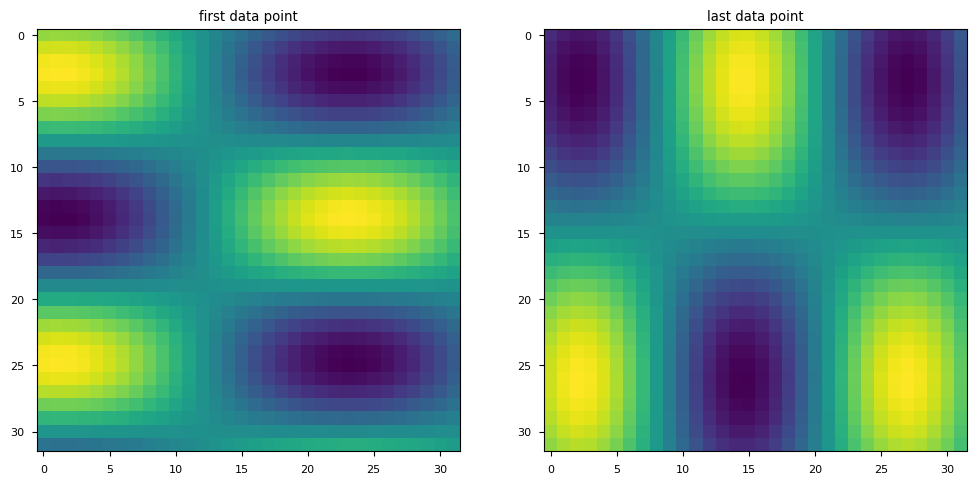

In [7]:
# Parameters
N = 32  # Sequence length
M = 32  # Number of features
num_samples = 1000

# Generate 2D sinusoidal data
data = generate_2d_sinusoidal_data(N, M, num_samples)
data.shape
# Plot original and reconstructed signals for a sample
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(data[0], cmap="viridis")
axes[0].set_title("first data point")
axes[1].imshow(data[-1], cmap="viridis")
axes[1].set_title("last data point")
plt.show()

## Create the POLCA-Net

### Create a POLCA-Net with an LSTM Encoder

In [8]:
ae_input = data
act_fn = torch.nn.Mish()
input_dim = ae_input[0].shape
latent_dim = 256
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"

encoder_lstm = autoencoder_factory(
    seq_len=input_dim[0],  #    N
    input_dim=input_dim[1],  #  M
    latent_dim=256,
    hidden_dim=None,
    num_layers=2,
    autoencoder_type="lstm",
    act_fn=act_fn,
)

decoder_lstm = LinearDecoder(latent_dim=latent_dim, input_dim=input_dim, hidden_dim=256, num_layers=3)

model_lstm = PolcaNet(
    encoder=encoder_lstm,
    decoder=decoder_lstm,
    latent_dim=latent_dim,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
    scaler=StandardScalerTorch(),
)
model_lstm

PolcaNet(
  (encoder): LSTMAutoencoder(
    (encoder): LSTMEncoder(
      (lstm): LSTM(32, 256, num_layers=2, batch_first=True)
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): NoActivation()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): NoActivation()
      (4): Linear(in_features=256, out_features=1024, bias=True)
    )
  )
  (polcanet_loss): PolcaNetLoss()
)

In [9]:
model_lstm.to_device("cuda:3")
model_lstm.train_model(data=data, batch_size=512, num_epochs=10000, report_freq=10, lr=1e-3, use_two_decoders=True)

TypeError: PolcaNet.train_model() got an unexpected keyword argument 'use_two_decoders'

In [ ]:
model_lstm.train_model(data=data, batch_size=512, num_epochs=1000, report_freq=10, lr=1e-4, use_two_decoders=True)

In [ ]:
analyze_reconstruction_error(model_lstm, data, n_samples=1000)

In [ ]:
latents, reconstructed = model_lstm.predict(data)
data.shape, reconstructed.shape, latents.shape

In [ ]:
# Plot original and reconstructed signals for a sample
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(data[0], cmap="viridis")
axes[0].set_title("Original")
axes[1].imshow(reconstructed[0], cmap="viridis")
axes[1].set_title("Reconstructed")
plt.show()

In [ ]:
analyze_latent_space(model_lstm, data=data)

In [ ]:
orthogonality_test_analysis(model_lstm, data)

In [ ]:
variance_test_analysis(model_lstm, data)

In [ ]:
linearity_tests_analysis(model_lstm, data)

---

### Create a POLCA-Net with a 2D Convolutional Encoder

In [10]:
ae_input = data
act_fn = torch.nn.SiLU
input_dim = ae_input[0].shape
latent_dim = 64
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"

encoder_conv = autoencoder_factory(
    seq_len=input_dim[0],  #    N
    input_dim=input_dim[1],  #  M
    latent_dim=latent_dim,
    hidden_dim=None,
    num_layers=None,
    autoencoder_type="conv2d",
    act_fn=act_fn,
)

decoder_conv = LinearDecoder(latent_dim=latent_dim * 4, 
                             input_dim=input_dim,
                             hidden_dim=1024,
                             num_layers=2)

model_conv = PolcaNet(
    encoder=encoder_conv,
    decoder=decoder_conv,
    latent_dim=latent_dim * 4,
    alpha=1.0,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
    # scaler=StandardScalerTorch(),
)
model_conv

PolcaNet(
  (encoder): ConvAutoencoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): SiLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): SiLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): SiLU()
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): SiLU()
      (8): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): NoActivation()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
    )
  )
  (polcanet_loss): PolcaNetLoss()
)

In [11]:
model_conv.to("cuda:3")
model_conv.train_model(data=data, batch_size=512, num_epochs=10000, report_freq=10, lr=1e-3)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
Total Loss: 0.001506
Reconstruction Loss: 0.0001484
Orthogonality Loss: 0.001238
Center of Mass Loss: 7.938e-05
Variance Distribution Loss: 4.009e-05


In [ ]:
model_conv.train_model(data=data, batch_size=512, num_epochs=10000, report_freq=10, lr=1e-4)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
analyze_reconstruction_error(model_conv, data, n_samples=10000)

In [ ]:
latents, reconstructed = model_conv.predict(data)
data.shape, reconstructed.shape, latents.shape

In [ ]:
# Plot original and reconstructed signals for a sample
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(data[0], cmap="viridis")
axes[0].set_title("Original")
axes[1].imshow(reconstructed[0], cmap="viridis")
axes[1].set_title("Reconstructed")
plt.show()

In [ ]:
plot_cumsum_variance(model_conv, data)

In [ ]:
analyze_latent_space(model_conv, data=data)

In [ ]:
orthogonality_test_analysis(model_conv, data)

In [ ]:
variance_test_analysis(model_conv, data)

In [ ]:
linearity_tests_analysis(model_conv, data)